<IPython.core.display.Javascript object>


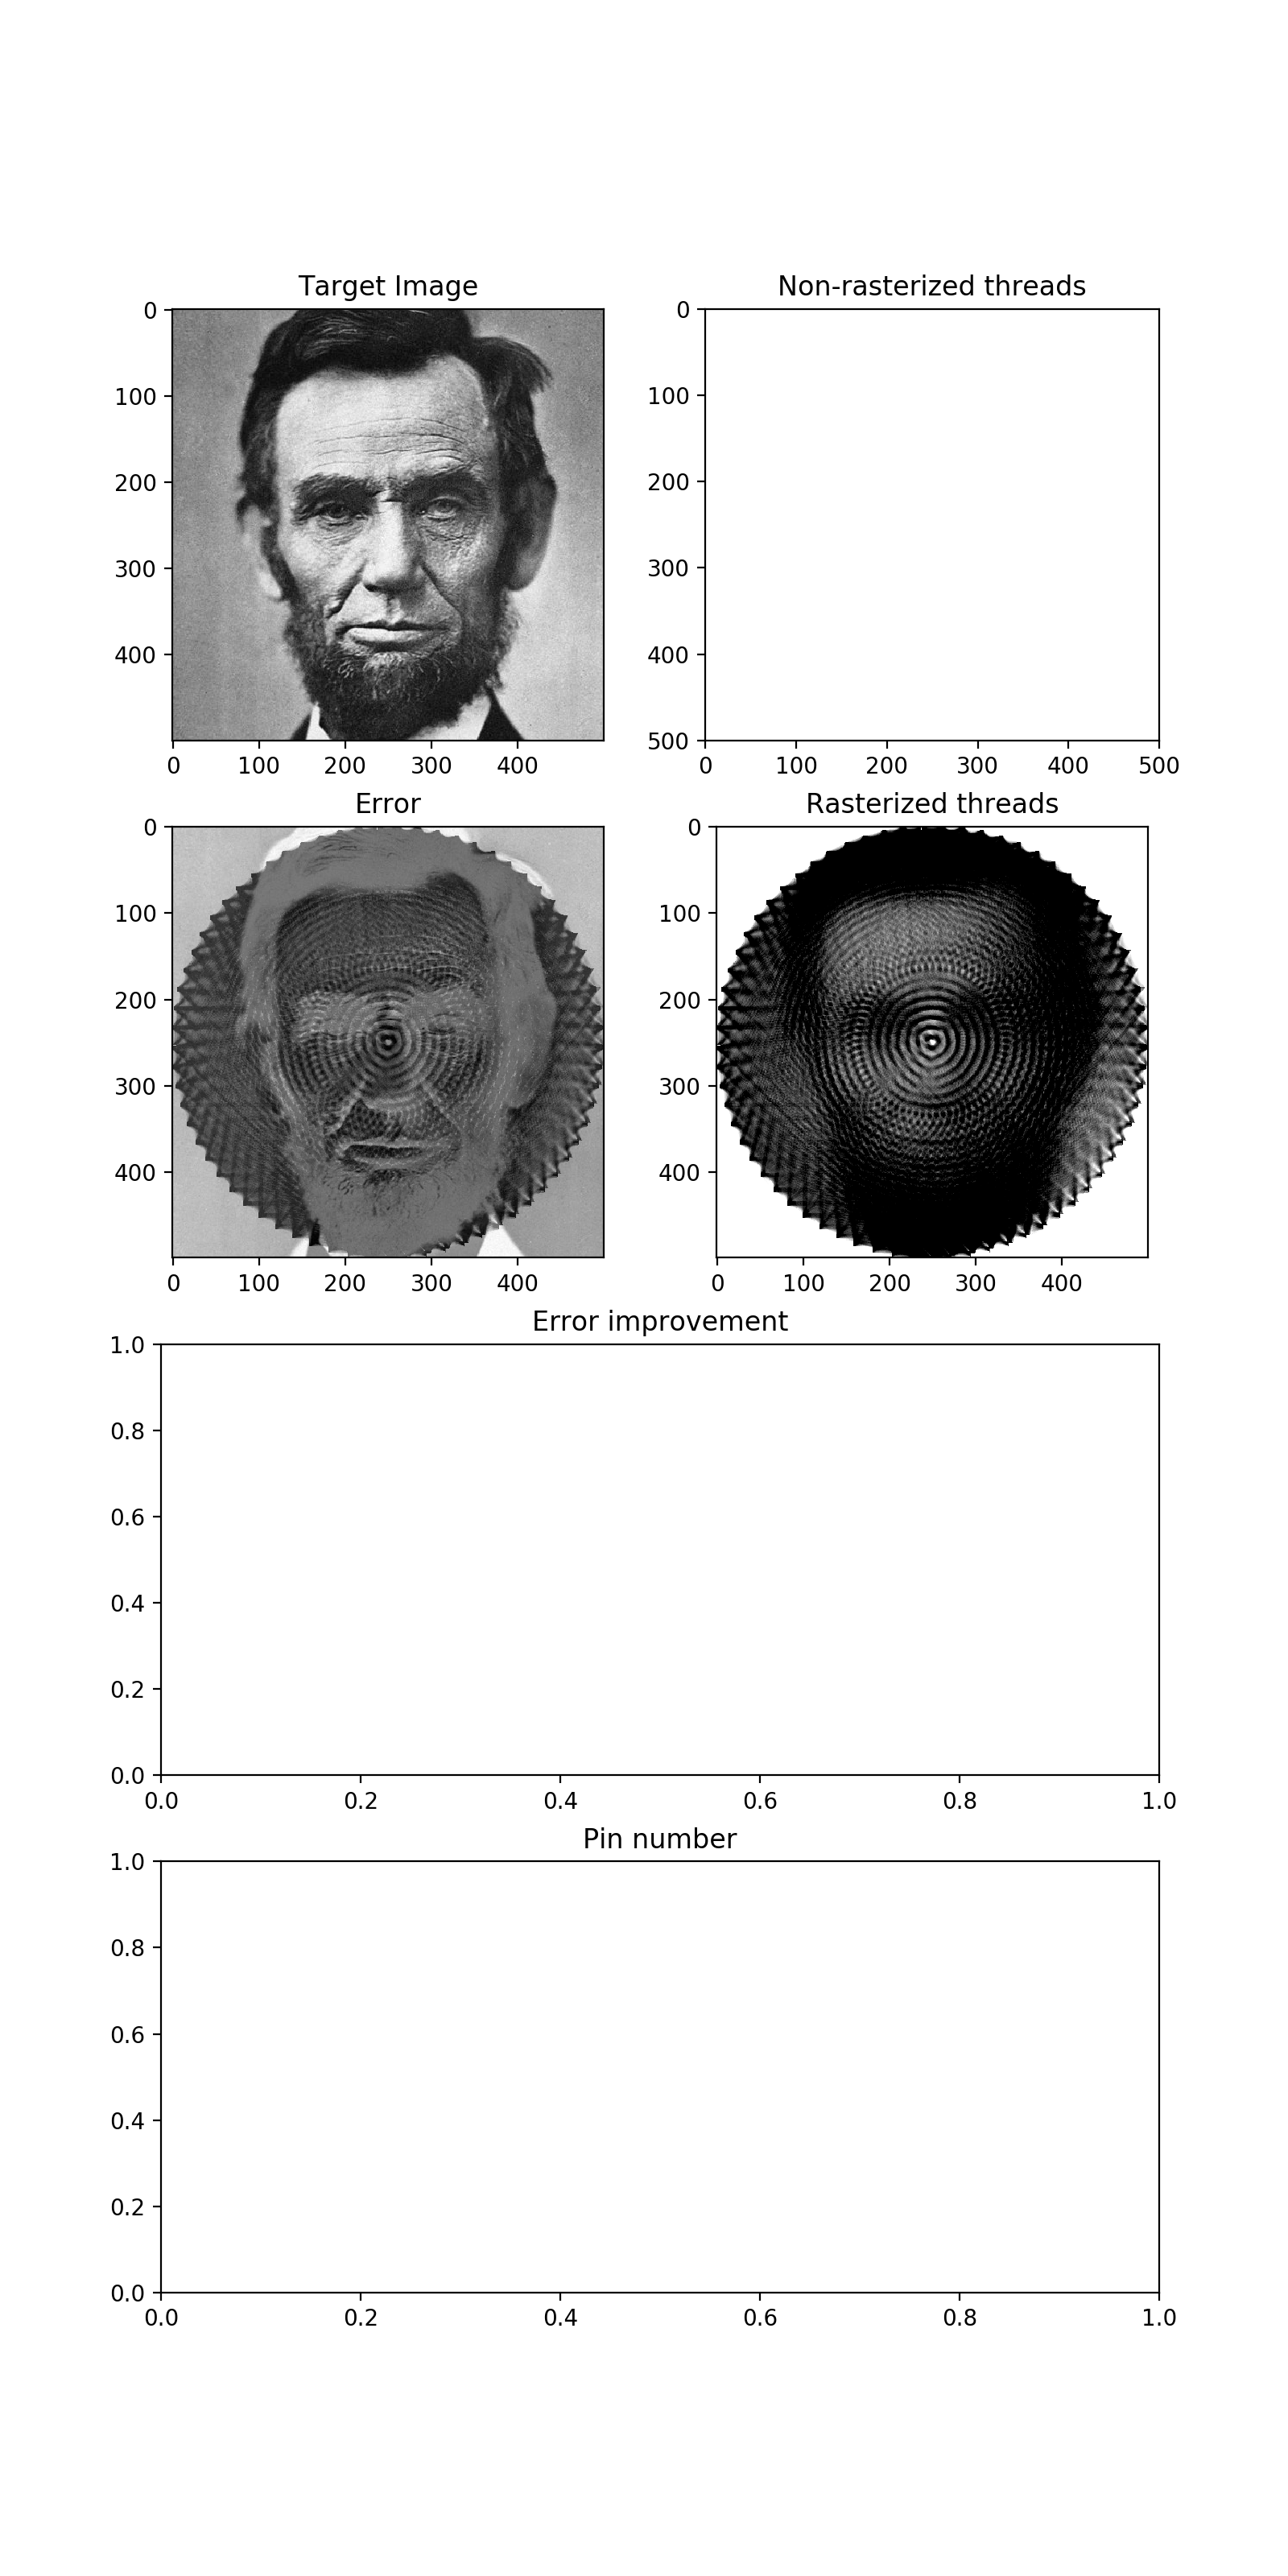

Figuring out pixel mappings to lines
Finding optimal lines
 
LSQR            Least-squares solution of  Ax = b
The matrix A has   250000 rows  and     4900 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =     9800
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.142e+04  7.142e+04    1.0e+00  4.2e-04
     1  0.00000e+00   4.832e+04  4.832e+04    6.8e-01  1.5e-01   4.1e+01  1.0e+00
     2  0.00000e+00   4.680e+04  4.680e+04    6.6e-01  3.5e-02   4.8e+01  2.3e+00
     3  0.00000e+00   4.667e+04  4.667e+04    6.5e-01  1.4e-02   5.4e+01  3.6e+00
     4  0.00000e+00   4.663e+04  4.663e+04    6.5e-01  9.5e-03   5.8e+01  5.1e+00
     5  0.00000e+00   4.661e+04  4.661e+04    6.5e-01  7.9e-03   6.2e+01  7.0e+00
     6  0.00000e+00   4.659e+04  4.659e+04    6.5e-01  6.0e-03   6.7e+01  9.5e+00
     7  0.00000e+00   4.657e+04  4.657e+04    6.5e-

In [150]:
import matplotlib.image as mpimg
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from bresenham import bresenham
from scipy import ndimage
from scipy.misc import imresize
import pickle
from random import randint
from scipy import stats
import itertools
from scipy.sparse import dok_matrix
from scipy.sparse.linalg import lsqr

%matplotlib nbagg
matplotlib.rcParams['figure.figsize'] = (8,16)

edge_size = 500
line_opacity = .04
num_points = 70
padding = 10
stopping_lookback = 10

# Circle Points
theta = np.linspace(0, 2*np.pi, num_points)
a, b = edge_size * (np.cos(theta)+1)/2-1, edge_size * (np.sin(theta)+1)/2-1
points = zip([int(i) for i in a],[int(i) for i in b])

def get_image(f='./nerea1.jpg'):
    img = ndimage.imread(f, flatten=True)
    return img

def pixel_to_pixelid(x,y):
    return x*edge_size+y

def pixelid_to_pixel(pixelid):
    return pixelid/edge_size,pixelid%edge_size

def points_to_lineid(p1,p2):
    p1,p2 = (p1,p2) if (p1<=p2) else (p2,p1)
    return p1*num_points+p2

def lineid_to_points(pixelid):
    return pixelid/edge_size,pixelid%edge_size


class Plot():
    def __init__(self):
        self.fig = plt.figure()#figsize=(8, 16))
        

        self.ax1 = plt.subplot2grid((4, 2), (0, 0))
        self.ax1.set_title("Target Image")
        self.ax2 = plt.subplot2grid((4, 2), (0, 1))
        self.ax2.set_title("Non-rasterized threads")
        self.ax2.set_xlim([0, edge_size])
        self.ax2.set_ylim([edge_size, 0])
        self.ax3 = plt.subplot2grid((4, 2), (1, 1))
        self.ax3.set_title("Rasterized threads")
        self.ax4 = plt.subplot2grid((4, 2), (1, 0))
        self.last_line = 0
        self.ax4.set_title("Error")
        self.ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2)
        self.ax5.set_title("Error improvement")
        self.ax6 = plt.subplot2grid((4, 2), (3, 0), colspan=2)
        self.ax6.set_title("Pin number")
        #self.fig.subplots(figsize=(20, 10))
        #plt.tight_layout()

    def show(self, img, raster, diff, points_log=None,errors=None, pins=None):
        self.ax1.imshow(img, cmap="gray")
        #lc = LineCollection([points_log[-1]], linewidths=2, alpha=0.01)
        #self.ax2.add_collection(lc)

        #self.ax2.plot(*zip(*points), 'b.')
        self.ax3.imshow(raster, cmap="gray")
        self.ax4.imshow(diff, cmap="gray")
        
        if points_log != None:
            for i in xrange(self.last_line, len(points_log)-1):
                line_x = [points[points_log[i]][0], points[points_log[i+1]][0]]
                line_y = [points[points_log[i]][1], points[points_log[i+1]][1]]
                self.ax2.plot(line_y, line_x, alpha=line_opacity, color="k")
        if errors!= None and points_log != None:
            self.ax5.plot(range(self.last_line,len(points_log)-1),errors[self.last_line:])
        if pins!= None and points_log != None:
            self.ax6.plot(range(self.last_line,len(points_log)-1),pins[self.last_line:-1])        
        self.fig.canvas.draw()
        if points_log!=None: self.last_line = len(points_log)
    
        
        
def get_next_point(prev,diff):
    best_score = -100
    starting_point =  points[prev[-1]]
    for i, proposed_point in enumerate(points):
        if (prev[-1]-i)%num_points < padding or (prev[-1]-i)%num_points > num_points - padding: continue        
        #if (len(prev)>1 and prev[-2]==i): continue
        proposed_line = get_line_pixels(starting_point,proposed_point,thickness = 1)
        score = 0
        for point in proposed_line:
            score = score + diff[point]*line_opacity
            #if diff[point]<line_opacity:
            #    score = score + diff[point]
            #else: 
            #    score = score + line_opacity
        if float(score)/len(proposed_line)>best_score:
            best_i=i
            best_score = float(score) / len(proposed_line)
    #print best_i 
    return best_i, best_score

def get_line_pixels(p1,p2,thickness = 5):
    line_points = []
    line_px = list(bresenham(p1[0], p1[1], p2[0], p2[1]))
    for px in line_px:
        if abs(p1[0]-p2[0])>abs(p1[1]-p2[1]):
            for j in xrange(thickness):
                if px[1]+j>=edge_size:
                    break
                line_points.append((px[0],px[1]+j))
        else:
            for j in xrange(thickness):
                if px[0]+j>=edge_size:
                    break
                line_points.append((px[0]+j,px[1]))
    return line_points

def get_error(lines,connections,img):
    error_img = np.dot(lines,connections) - img.reshape((edge_size,edge_size))
    return error_img


def get_lines(img):
    #indicates which lines touch which pixels
    connections = dok_matrix((edge_size**2, num_points**2), dtype=np.uint8) 
    #lines = np.zeros((num_points**2))
    
    
    # cycle through possible point_pairs (e.g. lines), 
    # then fill out a matrix that corresponds to which pixels they touch
    print "Figuring out pixel mappings to lines"
    for point_pair in itertools.combinations(range(num_points),2):
        #print point_pair
        line_pixels = get_line_pixels(points[point_pair[0]], points[point_pair[1]], thickness=1)
        line_id = points_to_lineid(point_pair[0],point_pair[1])
        for pixel in line_pixels:
            pixel_id = pixel_to_pixelid(pixel[0],pixel[1])
            connections[pixel_id,line_id] = 1
    
    print "Finding optimal lines"
    lines = lsqr(connections, img.reshape((-1,1)), damp = 0, show=True)#, atol=1.0e-11, btol=1.0e-11 )
    return lines[0]
    #get_img_from_lines(connections, lines)

def draw_line(img,pixels, opacity=line_opacity):
    for pixel in pixels:
        #img[pixel[0],pixel[1]] = max(img[pixel[0],pixel[1]] * (float(1)-line_opacity),0)
        #increment = .3 if invert==False else -.3
        img[pixel[0],pixel[1]] = img[pixel[0],pixel[1]]-opacity#line_opacity

def update_diff(diff, raster, img, pixels):
    for pixel in pixels:
        diff[pixel] = raster[pixel] - img[pixel]
    
def main():
    img = get_image('/Users/delbalso/Downloads/lincolnmed.jpg')
    img = imresize((img - img.min())/img.max()*255,(edge_size, edge_size))
    p = Plot()
    
    # Raster is the image we're drawing to simulate thread
    raster = np.zeros((edge_size, edge_size))+255
    assert raster.shape == img.shape
    
    diff = np.subtract(raster, img)
    method = "alg"
    if method=="greedy":
        i = 0
        errors = []
        
        points_log = [randint(0, len(points)-1)]
        while (len(errors)<stopping_lookback or 
               sum(errors[-stopping_lookback:]) > stopping_lookback*0.25):

            next_point, err = get_next_point(points_log[-1:],diff)
            points_log.append(next_point)
            errors.append(err)

            line_pixels = get_line_pixels(points[points_log[-2]],points[points_log[-1]])
            draw_line(raster,line_pixels)
            update_diff(diff, raster, img, line_pixels)

            if i%100==0: p.show(img,raster,diff,points_log, errors, points_log) 
            i = i+1
            print "Finished! We drew {0} lines".format(i)
    else:
        lines = get_lines(255-img)
        pickle.dump(lines, open("./save.p", "wb" ) )
        #lines = pickle.load( open( "./save.p", "rb" ) )


        
        for line_id, weight in enumerate(list(lines)):   
            p1 = line_id%num_points
            p2 = line_id/num_points
            #print "{0}  {1}  ({2},{3})".format(line_id,int(weight), p1, p2)
            
            line_pixels = get_line_pixels(points[p1],points[p2])
            #for i in xrange(abs(int(weight))):
            draw_line(raster, line_pixels, opacity=weight*.5)
        diff = np.subtract(np.clip(raster,0,255), img)
        p.show(img,np.clip(raster,0,255),diff) 
        #print stats.describe(diff)#["minmax"]
        #print stats.describe(img)["minmax"]
        #print stats.describe(raster)["minmax"]

if __name__ == "__main__":
    main()

In [99]:
Things to look into
https://github.com/danielvarga/string-art/blob/master/strings.py
Radon transform
Hough transform
https://github.com/theveloped/ThreadTone

SyntaxError: invalid syntax (<ipython-input-99-19cc8afa196d>, line 1)